# Noita 'Rickroll' QR Code Noise Analysis From Scratch

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/probable-basilisk/noita_qr_analysis/blob/main/qr_noise_analysis.ipynb)


I have heard it said that nobody has been able to 'replicate' this analysis so here it is, in a conveniently
runnable colab notebook, totally from scratch starting with nothing more than the qrcode image from in game
and ending with both the binary and grayscale noise tables and the list of row offsets.

In [ ]:
# if you are running in colab, you'll need to run this cell to download the qrcode
!wget -O qr.png https://github.com/probable-basilisk/noita_qr_analysis/blob/main/qr.png?raw=true

In [58]:
# common imports
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt
import itertools
import operator
import collections
import json
plt.rcParams['figure.figsize'] = [5, 5]

## Part 0: Data Prep / Isolating the Noise

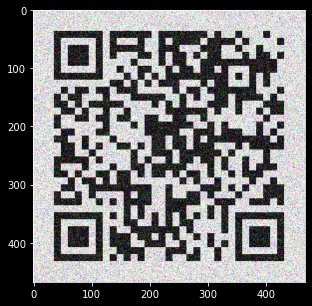

In [59]:
qrcode = cv2.imread("qr.png")
plt.imshow(qrcode)

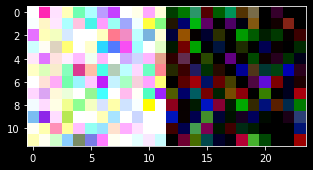

In [60]:
# First observations: the qrcode blocks are perfectly aligned to a 12x12 pixel grid
# This will simplify a lot of stuff
BLOCKSIZE = 12
IMAGEHEIGHT = qrcode.shape[0]
ROWSIZE = qrcode.shape[1]

def blockpos(row, col):
  return (row*BLOCKSIZE, col*BLOCKSIZE)

def extract_block(img, row, col, nrows=1, ncols=1):
  return img[row*BLOCKSIZE:(row+nrows)*BLOCKSIZE, col*BLOCKSIZE:(col+ncols)*BLOCKSIZE, :]

# Let's have a closer look at a white and black block
_ = plt.imshow(extract_block(qrcode, 5, 4, 1, 2))


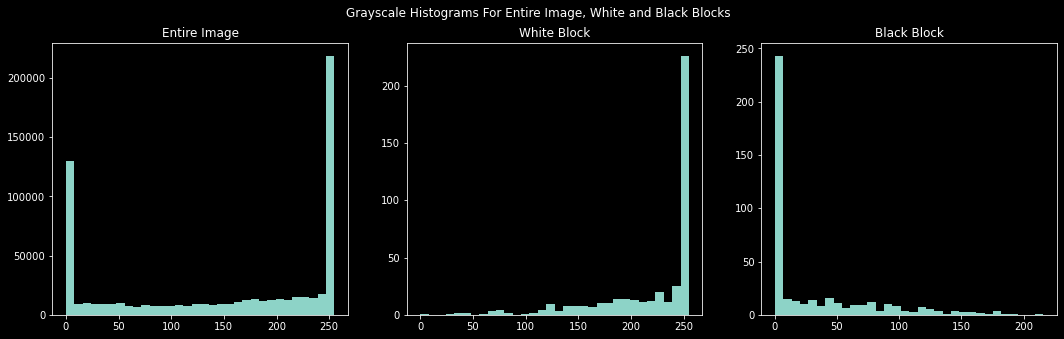

In [61]:
# Let's have a look at some histograms
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Grayscale Histograms For Entire Image, White and Black Blocks')

ax1.set_title("Entire Image")
_ = ax1.hist(qrcode.reshape((-1)), bins=32)

ax2.set_title("White Block")
_ = ax2.hist(extract_block(qrcode, 5, 4).reshape((-1)), bins=32)

ax3.set_title("Black Block")
_ = ax3.hist(extract_block(qrcode, 5, 5).reshape((-1)), bins=32)


#### Observations:

* a white block has a large number of 255s
* a black block a large number of 0s
* the histograms of white and black blocks are mirrors of each other.

#### Conclusion:

We can figure out if a block is 'white' or 'black' by just checking if it has
more 0s or 255s, and then we can turn white blocks into black blocks by
inverting the RGB values as `new_value = 255 - old_value`

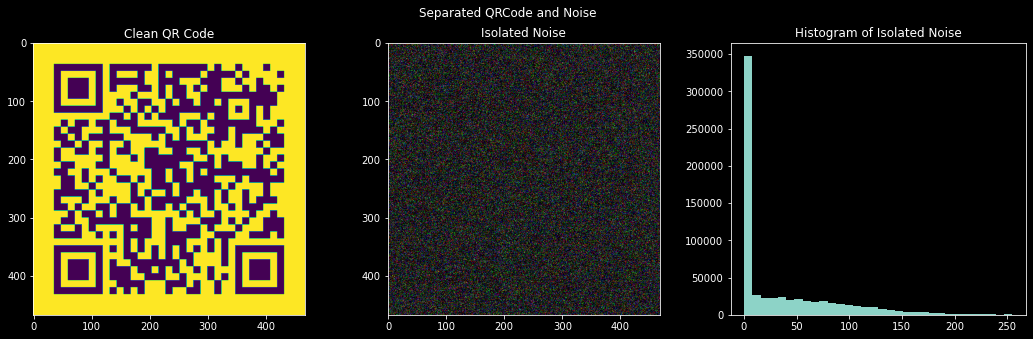

In [62]:
def clean_block(block):
  is_white = (np.sum(block == 255) > np.sum(block == 0))
  if is_white:
    return (1, 255 - block)
  else:
    return (0, block)

def isolate_noise_from_qrcode(img):
  noise_only = np.zeros_like(img)
  qrcode_only = np.zeros(img.shape[:2]).astype(int)
  nrows = img.shape[0] // BLOCKSIZE
  ncols = img.shape[1] // BLOCKSIZE
  for row in range(nrows):
    for col in range(ncols):
      y, x = blockpos(row, col)
      (color, noise) = clean_block(extract_block(img, row, col))
      qrcode_only[y:y+BLOCKSIZE, x:x+BLOCKSIZE] = color
      noise_only[y:y+BLOCKSIZE, x:x+BLOCKSIZE, :] = noise
  return (qrcode_only, noise_only)

qrcode_clean, isolated_noise = isolate_noise_from_qrcode(qrcode)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Separated QRCode and Noise')
ax1.set_title('Clean QR Code')
ax1.imshow(qrcode_clean)
ax2.set_title('Isolated Noise')
ax2.imshow(isolated_noise)
ax3.set_title('Histogram of Isolated Noise')
_ = ax3.hist(isolated_noise.reshape((-1)), bins=32)


Notice how we have now produced noise that has the histogram (distribution) of values in black blocks.

Our final step of data preparation is to split the noise into three images, one for each RGB channel, and produce a *binary*
version of the noise. As part of this prep, we also *XOR* the binary noise again with the clean QR code. 

Why? It makes the analysis work. 

The fact that you have to separately XOR the QRCode back into the binary noise is the reason
why you could reasonably say that there's a second level of rickroll.

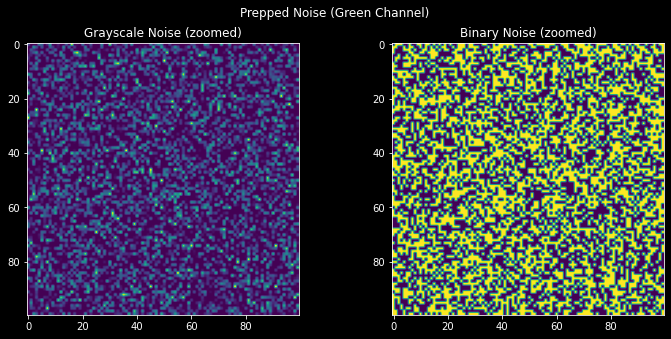

In [63]:
def prep_binary_noise(noise, clean_qr_code):
  return np.logical_xor(noise > 0, clean_qr_code > 0)

def prep_noise(isolated_noise, clean_qr_code):
  grayscale_noise = [isolated_noise[:, :, i] for i in range(3)]
  binary_noise = [prep_binary_noise(n, clean_qr_code) for n in grayscale_noise]
  return (grayscale_noise, binary_noise)

(grayscale_noise, binary_noise) = prep_noise(isolated_noise, qrcode_clean)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Prepped Noise (Green Channel)')
ax1.set_title('Grayscale Noise (zoomed)')
ax1.imshow(grayscale_noise[1][0:100, 0:100])
ax2.set_title('Binary Noise (zoomed)')
_ = ax2.imshow(binary_noise[1][0:100, 0:100])


## Part 1: Extracting the Noise Table & Row Offsets

All the binary noise is actually drawn from a relatively small table of values: each row is simply a slice of a 4559 large noise table.
Here we extract that table *from scratch* starting with nothing more than the assumption that every row of binary noise
comes out of some larger noise sequence.

First, we're going to look for rows that have *exact overlaps* with other rows. To do this efficiently (i.e., without O(n^2) comparing
every row to every other row) we will build a hash table of every `MATCH_BITS` window of every row, and then check each row's
*tail* (the last `MATCH_BITS` of that row) against the hash table. Here I set `MATCH_BITS` to 32 so that the probability of accidentally
matching rows is so incredibly low that we can ignore the possibility.

In [64]:
# first, dealing with three color channels separately is annoying, so
# we're going to just stack the color channels into one 3x tall image
binary_noise_stacked = np.vstack(binary_noise)

# How many bits of exact match we need to link two rows.
# Note that 32 bits of exact match means the likelihood of
# a false positive, assuming uniform random binary noise, is about
# one in four billion. In other words, we would have to get
# extraordinarily unlucky to accidentally match two rows by chance.
MATCH_BITS = 32

# Convenience for easily turning a binary array into an integer
PLACE_VALUES = 2 ** np.arange(MATCH_BITS)

Now, we build up the hash table and then prune it to produce a directed graph of overlapping rows.

In [65]:
# Convert the last MATCH_BITS values of each row into an integer
# (just treat it as a binary number)
def calculate_row_tails(img):
  img = img.astype(int)
  return img[:, -MATCH_BITS:] @ PLACE_VALUES

# Create a dictionary that maps a *tail* (integer value)
# to the possible next rows that link to it
def create_possible_successors_map(noise):
  noise = noise.astype(int)
  successors = collections.defaultdict(set)
  # We iterate to width-1 because we do not want rows
  # to match with themselves: a successor needs to actually
  # *grow* the chain.
  for offset in range(noise.shape[1]-MATCH_BITS-1):
    windows = noise[:, offset:offset+MATCH_BITS]
    hashes = windows @ PLACE_VALUES
    for row, val in enumerate(hashes):
      successors[val].add((row, offset))
  return successors

# Count how many bits match between the tail of row_a
# and the candidate position pos in row_b
def count_alignment(row_a, row_b, pos):
  # =======|MATCH_BITS]        row_a
  #    [===|MATCH_BITS|======  row_b
  #        ^
  #        pos
  #    ~~~~~~~~~~~~~~~~ overlap
  overlap = pos + MATCH_BITS
  count = np.sum(row_a[-overlap:] == row_b[:overlap])
  return (count, overlap)

# Take the candidate successors and only keep the
# ones that actually exactly match in their overlaps
def prune_successors(candidates, rowidx, rows):
  successors = []
  for (candidx, pos) in candidates:
    (count, total) = count_alignment(rows[rowidx, :], rows[candidx, :], pos)
    if count == total:
      successors.append((candidx, pos, count))
  return successors

def create_successors(noise):
  succ = {}
  cand = create_possible_successors_map(noise)
  tails = calculate_row_tails(noise)
  for (rowidx, tail) in enumerate(tails):
    succ[rowidx] = prune_successors(cand[tail], rowidx, noise)
  return succ

succ = create_successors(binary_noise_stacked)


Next we search that graph to find the longest chain of overlapping rows.

In [66]:
# we do this with memoization/dynamic programming:
# we keep a dictionary ('longests') that keeps track of
# the longest chain rooted at a given row.
def _longest_rooted_chain(root, succ, longests):
  if root in longests:
    return longests[root]
  # prevent infinite recursion if cyclic
  longests[root] = ((0, 0), ROWSIZE)
  max_length = ROWSIZE
  max_succ = (-1, -1)
  for (idx, pos, count) in succ[root]:
    (_, sublength) = _longest_rooted_chain(idx, succ, longests)
    length = ROWSIZE + (sublength - (pos + MATCH_BITS))
    if length > max_length:
      max_length = length
      max_succ = (idx, pos)
  (idx, pos) = max_succ
  longests[root] = ((idx, pos), max_length)
  return longests[root]

# Then to find the globally longest chain, we just
# try every possible starting point.
def longest_chain(succ):
  longests = {}
  max_chain = -1
  max_idx = -1
  for rowidx in succ.keys():
    (_, length) = _longest_rooted_chain(rowidx, succ, longests)
    if length > max_chain:
      max_chain = length
      max_idx = rowidx
  chain = [(max_idx, 0)]
  curidx = max_idx
  offset = 0
  while True:
    ((nextidx, pos), _) = longests[curidx]
    if nextidx < 0:
      break
    curidx = nextidx
    offset += ROWSIZE - (pos + MATCH_BITS)
    chain.append((curidx, offset))
  return max_chain, chain

def assemble_chain(noise, chain):
  chain_length = max(offset + ROWSIZE for (_, offset) in chain)
  res = np.zeros(chain_length).astype(noise.dtype)
  for (rowidx, offset) in chain:
    res[offset:offset+ROWSIZE] = noise[rowidx, :]
  return res

chainsize, chain = longest_chain(succ)
print("Found a chain of size:", chainsize)


Found a chain of size: 4559


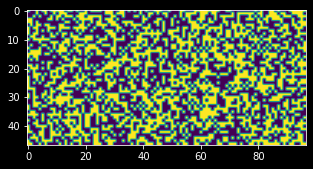

In [67]:
initial_noisetable = assemble_chain(binary_noise_stacked, chain)
# if everything went correctly you should have gotten a noise table that's 4559 long,
# which is conveniently 47*97 so we can display it as rectangular image:
if chainsize == 4559:
  plt.imshow(initial_noisetable.reshape((47, 97)))

#### Finding The Row Offsets

Now, we find each noise row's position in the noise table by just trying every position and picking
the one with the maximum similarity. 

Rows do not always have a perfect match in the noise table: they can differ by a few pixels. But we'll
find that on average each row will have a >99% match to some location in the noise table.

In [68]:
def find_row_offsets(noisetable, noise):
  offsets = []
  match_ratios = []
  # transform from [0, 1] -> [-1, 1]
  # (this is nicer for np.correlate)
  table_normalized = noisetable.astype(float) * 2.0 - 1.0
  noise_normalized = noise.astype(float) * 2.0 - 1.0
  rowsize = noise.shape[1]
  for (rowidx, row) in enumerate(noise):
    # we use np.correlate to find the position of maximum correlation
    # (this is vastly faster than for-looping ourselves)
    pos = np.argmax(np.correlate(
        table_normalized, noise_normalized[rowidx, :]))
    count = np.sum(row == noisetable[pos:pos+rowsize])
    offsets.append(pos)
    match_ratios.append(count / rowsize)
  return offsets, match_ratios

(row_offsets, match_ratios) = find_row_offsets(initial_noisetable, binary_noise_stacked)
print("Mean match ratio:", np.mean(match_ratios))


Mean match ratio: 0.9920160956485743


#### Refining the Noise Table

The noise table we have already is pretty good, but since rows can differ by a few pixels we can try to
get a better noise table by using the offsets we just calculated to figure out the value in the noise
table that is *most consistent* with the rows that overlap it.

New mean match ratio: 0.9943659142377091


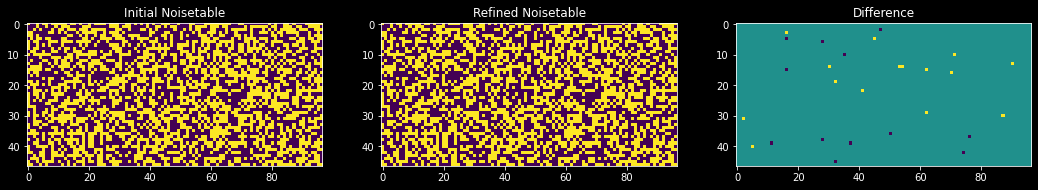

In [69]:
# Given a noise image and each row's offset into a noisetable,
# produce the noisetable that is *most consistent* with the image
def maximally_consistent_noisetable(offsets, noise):
  tablesize = np.max(offsets) + ROWSIZE

  # Place each row into the noise table and keep track of
  # how many 1s we see at each position, in addition to how many
  # rows 'see' that position in the table at all
  nones = np.zeros(tablesize)
  ncounts = np.zeros(tablesize)
  for row, offset in enumerate(offsets):
    nones[offset:offset+468] += noise[row, :]
    ncounts[offset:offset+468] += 1

  # the output noise table
  noisetable = np.zeros(tablesize)

  # set each noise table value to be the most common value
  # it has seen
  for idx in range(tablesize):
      none = nones[idx]
      ncount = ncounts[idx]
      if none > ncount / 2:
          noisetable[idx] = 1

  return noisetable

refined_noisetable = maximally_consistent_noisetable(
    row_offsets, binary_noise_stacked)

(refined_row_offsets, match_ratios) = find_row_offsets(
    refined_noisetable, binary_noise_stacked)
print("New mean match ratio:", np.mean(match_ratios))

if len(initial_noisetable) == 4559:
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
  ax1.set_title('Initial Noisetable')
  ax1.imshow(initial_noisetable.reshape((47, 97)))
  ax2.set_title('Refined Noisetable')
  ax2.imshow(refined_noisetable.reshape((47, 97)))
  ax3.set_title('Difference')
  diff = initial_noisetable.astype(float) - refined_noisetable.astype(float)
  ax3.imshow(diff.reshape((47, 97)))


Note that refining the noise table changed only a few dozen pixels and very slightly improved the match ratio.

### TODO: Grayscale table Extraction

## Part 2: Cursory Observations of the Binary Noise Table

So the 4559 binary noise table itself looks very similar to uniform random binary data. The number of 0s and 1s is very balanced, so no surprises there.

Text(0.5, 1.0, 'Histogram of Binary Noise Table')

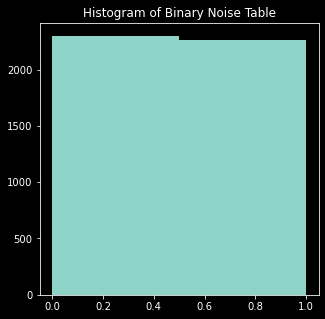

In [70]:
_ = plt.hist(refined_noisetable, bins=2)
plt.title("Histogram of Binary Noise Table")

Visually, qualitatively, the noisetable also looks very much like uniform random data.

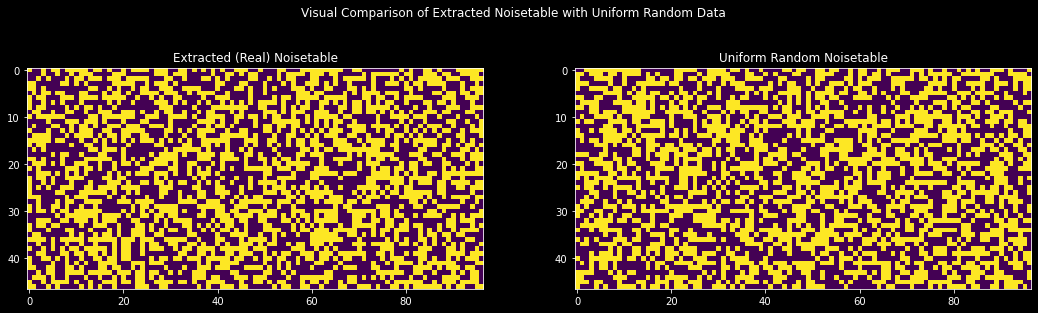

In [71]:
if len(refined_noisetable) == 4559:
  genuine_random_noisetable = np.random.randint(0, 2, refined_noisetable.shape)
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
  fig.suptitle('Visual Comparison of Extracted Noisetable with Uniform Random Data')
  ax1.set_title('Extracted (Real) Noisetable')
  ax1.imshow(refined_noisetable.reshape((47, 97)))
  ax2.set_title('Uniform Random Noisetable')
  ax2.imshow(genuine_random_noisetable.reshape((47, 97)))

## Part 3: Initial Analysis of the Offsets

### Histograms and plots why not

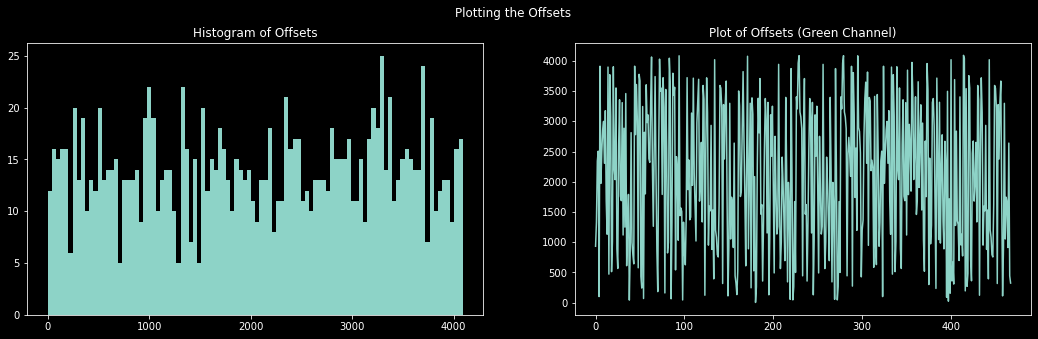

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('Plotting the Offsets')
ax1.set_title('Histogram of Offsets')
ax1.hist(refined_row_offsets, bins=100)
ax2.set_title('Plot of Offsets (Green Channel)')
ax2.plot(refined_row_offsets[468:468+468])

Nothing obviously stands out.


### Finding Repeated Sequences

Since we know every row's location in the noise table, we can now semi-efficiently look
for repeated sequences of noise (because they will consist of a repeated sequence of row offsets).

For this part, we are going to find every repeat that is at least two rows large: note that since
there are 4559 - 468 = 4091 possible offsets, the expectation of seeing a repeat of length two
by chance is roughly on the order of (468*3)/(4091^2) ~= one in ten thousand. So if the offsets were
generated uniformly at random, we really wouldn't expect to see even a single small repeat.

In [73]:
def identical_run_length(seq, p0, p1):
  count = 0
  for a, b in zip(seq[p0:], seq[p1:]):
    if a != b:
      break
    count += 1
  return count

def find_repeated_offset_sequences(offsets):
  # first, build a map from offset -> row[]
  offset_positions = collections.defaultdict(list)
  for rowidx, offset in enumerate(offsets):
    offset_positions[offset].append(rowidx)

  runs = collections.defaultdict(int)
  runmatches = collections.defaultdict(list)

  for offset, positions in offset_positions.items():
    if len(positions) <= 1:
      # this offset only occurs once so can't repeat
      continue
    for row_a, row_b in itertools.combinations(positions, 2):
      runlen = identical_run_length(offsets, row_a, row_b)
      if runlen > 1:
        earlier_row = min(row_a, row_b)
        runs[earlier_row] = runlen
        runmatches[earlier_row].append(max(row_a, row_b))

  run_positions = sorted(runs.keys())
  for rowidx in run_positions:
    rl = runs[rowidx]
    if rl <= 1:
      continue
    for idx in range(1, rl+1):
      if runs[rowidx+idx] == rl-idx:
        runs[rowidx+idx] = 0

  ret = []
  for rowidx, run_length in runs.items():
    if run_length > 1:
      ret.append((run_length, rowidx, runmatches[rowidx][0]))
  return ret

def rowpos_to_imagepos(rowpos):
  channel = ['B', 'G', 'R'][rowpos // IMAGEHEIGHT]
  ypos = rowpos % IMAGEHEIGHT
  return (channel, ypos)

repeats = find_repeated_offset_sequences(refined_row_offsets)
for (repeat_length, row_a, row_b) in repeats:
  (ca, ya) = rowpos_to_imagepos(row_a)
  (cb, yb) = rowpos_to_imagepos(row_b)
  print(f"Repeat length {repeat_length} @ {ca}{ya}-{ya+repeat_length} matching {cb}{yb}-{yb+repeat_length}")

Repeat length 42 @ G117-159 matching G426-468
Repeat length 32 @ G0-32 matching G319-351
Repeat length 50 @ G184-234 matching G234-284
Repeat length 18 @ R0-18 matching R333-351
Repeat length 2 @ R117-119 matching R466-468
Repeat length 66 @ R168-234 matching R234-300


So, unlike the noisetable itself which doesn't have any obvious non-random characteristics, the
offsets into that noisetable have six repeats, five of which are so substantially large as to 
be effectively impossible by chance.

Visualizing the locations of the repeats as just solid colors:

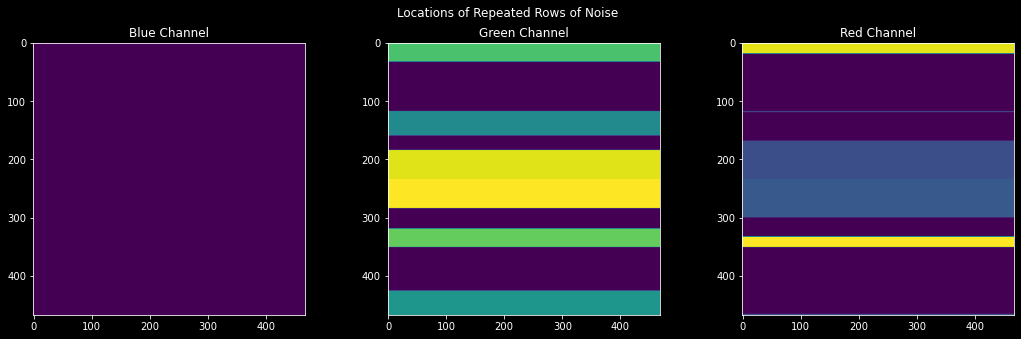

In [74]:
def vis_repeats(reps):
  # put more colors here if you need them
  COLORS = [100, 150, 200, 240, 50, 60, 70, 80] 

  dest = np.zeros((IMAGEHEIGHT*3, ROWSIZE), dtype=np.uint8)
  for color, (length, a, b) in zip(COLORS, reps):
    dest[a:a+length] = color
    dest[b:b+length] = color+10

  return dest

repeats_img = vis_repeats(repeats)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Locations of Repeated Rows of Noise')
ax1.set_title('Blue Channel')
ax1.imshow(repeats_img[:IMAGEHEIGHT,:])
ax2.set_title('Green Channel')
ax2.imshow(repeats_img[IMAGEHEIGHT:2*IMAGEHEIGHT,:])
ax3.set_title('Red Channel')
ax3.imshow(repeats_img[2*IMAGEHEIGHT:])

#### Observations

* There are no repeats in the blue channel.
* The red and green channels each have three repeats.
* The repeats in both channels are arranged in an ABCCAB pattern.
* Every repeat has either its start or end aligned to an exact quarter of the image height (multiple of 117).
* Every repeat has an even length (6 repeats, so about a 1/64th chance).

The number and size of the repeats rule out coincidence, while the arrangement of the repeats 
seems to bear the hallmarks of deliberate placement for some purpose.

The alignment of the repeats has a kind of mirror symmetry around the vertical center of the image,
but it's not clear why. Does this suggest that some kind of folding operation needs to be done?